Based on https://www.ai.rug.nl/minds/uploads/ESNTutorialRev.pdf

### Feedforward Networks
- Activation is from input to output through "hidden layers"
- input output mappings theoretically
- MLP (Muli-Layer Perceptrons) can approximate arbitrary nonlinear maps with arbitrary precision
- Most popular training algorithm is back-propogation
### Recurrent Neural Network (RNN)
- has at least one cyclic path
- All biological neural networks are recurent
- RNN implement dynamical systems
- Several types of training algorithms
- Can be used for system identification
- filtering and prediction
- pattern classification
- stochastic sequence modeling
- data compression
- robotics

We consider the discrete time model $ x_i(n+1) = f(\sum w_{ij} x_j (n)) $

$w_{ij} $ is the weight of the directed edge from node $j$ to node $i$

Let $K$ be the dimension of the input signal $\mathbf{u}(n)$

Let $N$ be the dimension of the network $\mathbf{x}(n)$

Let $L$ be the dimension of the output signal $y$(n)

Note that $\mathbf{u}$, $\mathbf{x}$, $\mathbf{y}$ are all column vectors

We define the following matrices:
- Let $W^{in} : \mathbb{R}^K \rightarrow \mathbb{R}^N$ map the input signal $\mathbf{u}$ to the node space $\mathbf{x}$.
- Let $W : \mathbb{R}^N \rightarrow \mathbb{R}^N$ consist of weights $(w_{ij})$ from node $x_j$ to node $x_i$
- Let $W^{out} : \mathbb{R}^{K+N} \rightarrow \mathbb{R}^L$ be the mapping from the nodes and the input signal to the output signal.
- Let $W^{back} : \mathbb{R}^L \rightarrow \mathbb{R}^N$ be the optional mapping from the output space back onto the nodes

The key equations are:
- $\mathbf{x}(n+1) = \mathbf{f}(\mathbf{W}^{in} \mathbf{u}(n+1) + \mathbf{W} \mathbf{x}(n) + \mathbf{W}^{back} \mathbf{y}(n))$
- $\mathbf{y}(n+1) = \mathbf{f}^{out}(\mathbf{W}^{out}(\mathbf{u}(n+1),\mathbf{x}(n+1)))$

Note that $(\mathbf{u}(n+1),\mathbf{x}(n+1))$ is the concatenated vector. Usually $\mathbf{f}$ and $\mathbf{f}^{out}$ are $\tanh$

## Example: A little timer network
Let $K=2$ and $L=1$ We wish to train a recurrent neural network of size $N$ nodes such that when $u_1(n0) == 1, u_2(n0) = t$ then $y(n) = 1$ for $n < t+n0$

In [1]:
using Random
using Plots
using LinearAlgebra

In [50]:
K = 2;
L = 1;
N = 2;
Wⁱⁿ = rand(Float64, (N,K));
W = UniformScaling(1.0);
Wᵇᵃᶜᵏ = rand(Float64, (N,L));
f = tanh;
fᵒᵘᵗ = tanh;
max_time = 100;
times = 1:1:max_time;
u = zeros((max_time,2));
yʳᵉᶠ = zeros(Float64, length(times));
i = 1
while i < max_time
    u[i,1] = rand([0,0,0,0,1]);
    if(u[i,1]==1)
        u[i,2] = rand(0.1:0.1:1.0);
        max = floor(Int, min(i+10*u[i,2], 100));
        u[i:end,2] .= u[i,2];
        yʳᵉᶠ[i:max] .= 0.5;
        i = max+10;
    else
        i = i+1;
    end
end

x = zeros(Float64, (length(times), N));
y = zeros(Float64, length(times));
x[1,:] = rand(Float64, N);

# Training
for n in times[1:49]
    x[n+1,:] = f.(Wⁱⁿ*u[n+1,:] + W*x[n,:] + Wᵇᵃᶜᵏ*y[n]);
end

# Optimization
alpha = 0.25;
X = [u[:50,:];x[:50,:]];
Wᵒᵘᵗ = (X'*X + alpha^2)\X'*yʳᵉᶠ[:50];

# Testing
for n in times[50:end-1]
    x[n+1,:] = f.(Wⁱⁿ*u[n+1,:] + W*x[n,:] + Wᵇᵃᶜᵏ*y[n]);
    y[n+1] = fᵒᵘᵗ.(Wᵒᵘᵗ*[u[n+1,:];x[n+1,:]]);
end
Wᵒᵘᵗ

1×4 adjoint(::Vector{Float64}) with eltype Float64:
 0.0  0.18932  0.217116  0.178447

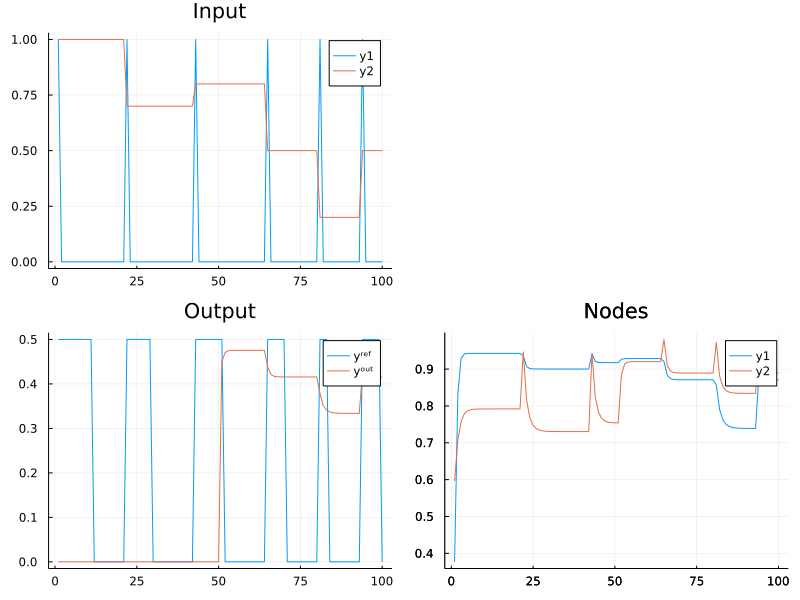

In [51]:
input_plot = plot(times, u, title="Input")
output_plot = plot(times, yʳᵉᶠ, label="yʳᵉᶠ", title="Output")
plot!(times, y, label="yᵒᵘᵗ")
node_plot = plot(times, x, title="Nodes")
plot(input_plot, node_plot, output_plot, node_plot, layout=(2,2), size=(800,600))